In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import tqdm as notebook_tqdm

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=False
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 1.0

sns.set_style("darkgrid")
np.random.seed(42)

colors = ['red', 'green', 'blue', 'magenta', 'cyan']

/home/murakami/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/murakami/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データ生成

### スペクトル生成

In [2]:
K = 4
N = 100
D = 50

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


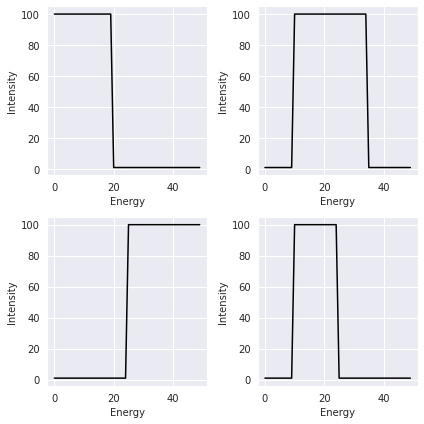

In [3]:
W_t = np.ones([D, K])
W_t[:20, 0] = 100
W_t[10:35, 1] = 100
W_t[25:, 2] = 100
W_t[10:25, 3] = 100
W_t = jnp.array(W_t)

plt.figure(figsize=(6, 6))
for k in range(K):
    plt.subplot(K//2, K//2, k+1)
    plt.plot(W_t[:, k], color='k')
    plt.xlabel('Energy')
    plt.ylabel('Intensity')
plt.tight_layout()
plt.show()



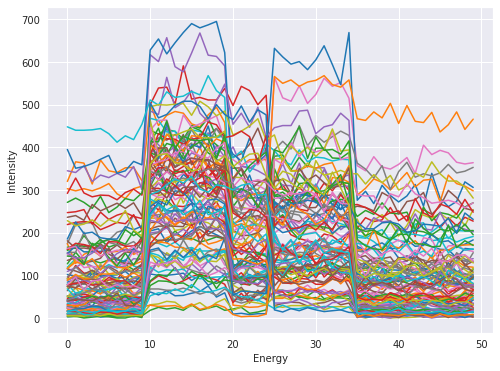

In [4]:
H_t = np.random.gamma(shape=1, scale=1, size=(K, N))
X = np.random.poisson(W_t@H_t)

plt.figure(figsize=(8, 6))
for n in range(N):
    plt.plot(X[:, n])
plt.xlabel('Energy')
plt.ylabel('Intensity')
plt.show()

### ターゲット変数の生成

In [5]:
w_t = jnp.array([1.0, 1.5, -1.0, -1.5])
f_t = w_t@H_t
y = f_t + np.random.normal(loc=0, scale=0.7, size=N)

### 通常のNMF
複雑な系だと真の構造を捉えることができていない．

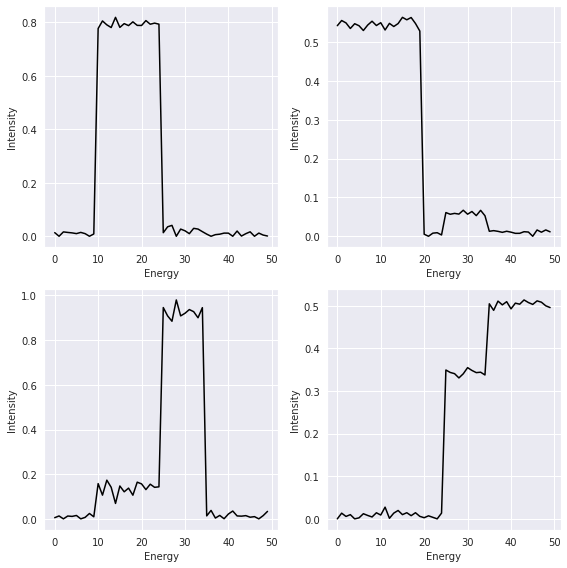

In [6]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=K, init="random", random_state=123, max_iter=1500)
W = nmf.fit_transform( X / np.max(X) )
H = nmf.components_

plt.figure(figsize=(8, 8))
for k in range(K):
    plt.subplot(K//2, K//2, k+1)
    plt.plot(W[:, k], c='k')
    plt.xlabel('Energy')
    plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

## 解析モデル

In [7]:
def model(K, X, y):
    
    ## スペクトル生成
    ## --------------------------------------------------------------------------------
    # D×Kの行列W
    W = numpyro.sample("W", dist.Gamma(concentration=1, rate=0.01).expand([D, K]))
    # K×Nの行列H
    H = numpyro.sample("H", dist.Gamma(concentration=1, rate=1).expand([K, N]))
    
    with numpyro.plate("energy", X.shape[0], dim=-2):
        with numpyro.plate("sample", X.shape[1], dim=-1):
            numpyro.sample("X", dist.Poisson(W@H), obs=X)
 
    ## ターゲット予測
    # --------------------------------------------------------------------------------
    # observation noise
    sigma = numpyro.sample("sigma", numpyro.distributions.HalfNormal(1.0)) 
    
    # beta = numpyro.sample("beta", numpyro.distributions.Normal(0, 10).expand([H.shape[0]])) 
    beta = numpyro.deterministic("beta", jnp.linalg.lstsq(H.T, y, rcond=None)[0])
    
    # f = numpyro.deterministic("f", w@H)
    # observation model
    with numpyro.plate("sample", X.shape[1]):
        numpyro.sample("y", numpyro.distributions.Normal(beta@H, sigma), obs=y) 
    

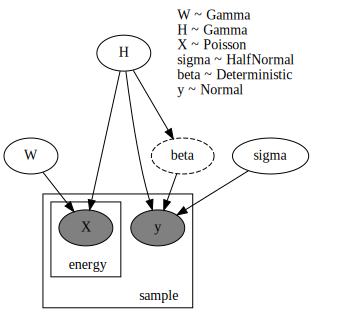

In [8]:
numpyro.render_model(
    model=model, 
    model_kwargs={"K": K, "X": X, "y": y},
    render_params=True, 
    render_distributions=True,
    # filename='prob_model.jpg',
)

### サンプリング

In [9]:
rng_key = jax.random.PRNGKey(42)
num_samples = 5000

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_samples,
                            num_samples=num_samples)
mcmc.run(rng_key=rng_key, K=K, X=X, y=y)

samples = mcmc.get_samples()

sample: 100%|██████████| 10000/10000 [01:34<00:00, 106.20it/s, 127 steps of size 4.66e-02. acc. prob=0.87]


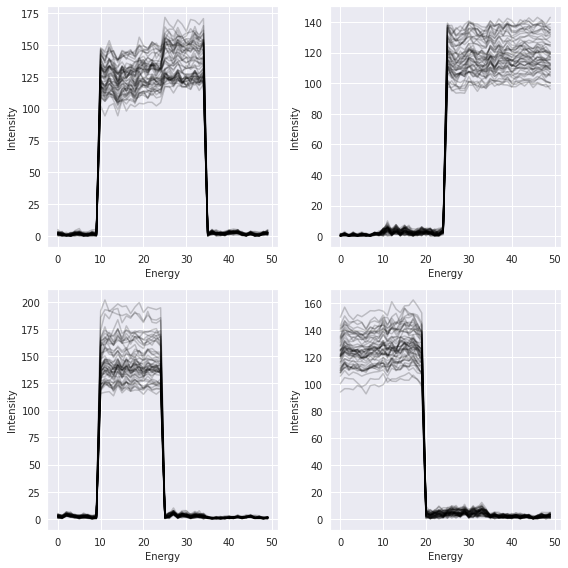

In [10]:
plt.figure(figsize=(8, 8))
for k in range(K):
    plt.subplot(K//2, K//2, k+1)
    c = colors[k]
    for i in range(0, 250, 5):
        plt.plot( samples['W'][-i, :, k], alpha=0.2, color='black')
    plt.xlabel('Energy')
    plt.ylabel('Intensity')
plt.tight_layout()
plt.show()

In [11]:
log_likelihood = numpyro.infer.log_likelihood(model=model, posterior_samples=mcmc.get_samples(), K=K, X=X, y=y)
log_likelihood = -1.0 * ( np.sum(log_likelihood['y'], axis=1) + np.sum(log_likelihood['X'], axis=[1, 2]) )
print( float( jnp.mean( log_likelihood ) ) )

18913.4140625


In [12]:
index = np.argmin(log_likelihood)
print(log_likelihood[index])

eap_beta = samples['beta'][index, :]
eap_H = samples['H'][index, :]

18858.643


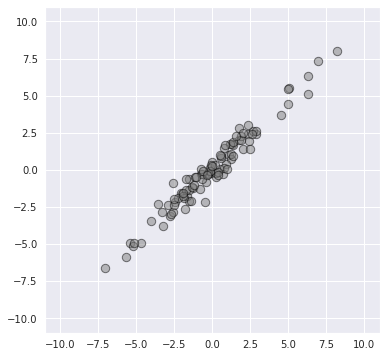

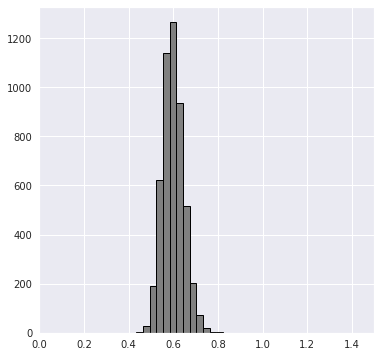

In [13]:
plt.figure(figsize=(6, 6))
y_hat = eap_beta@eap_H
plt.scatter(y, y_hat, c='gray', edgecolor='k', s=70, alpha=0.5)
plt.xlim(-11, 11)
plt.ylim(-11, 11)
plt.show()

plt.figure(figsize=(6, 6))
plt.hist(samples['sigma'], color='gray', edgecolor='k', bins=15)
plt.xlim(0, 1.5)
plt.show()